Importing necessary libraries:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Loading the Data

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0
batch_size = 20
valid_size = 0.2

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

train_data = datasets.CIFAR10('data', train = True, download =True, transform = transform)
test_data = datasets.CIFAR10('data', train = False, download = True, transform = transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


## Visualizing a Batch Of Training Data

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img/2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

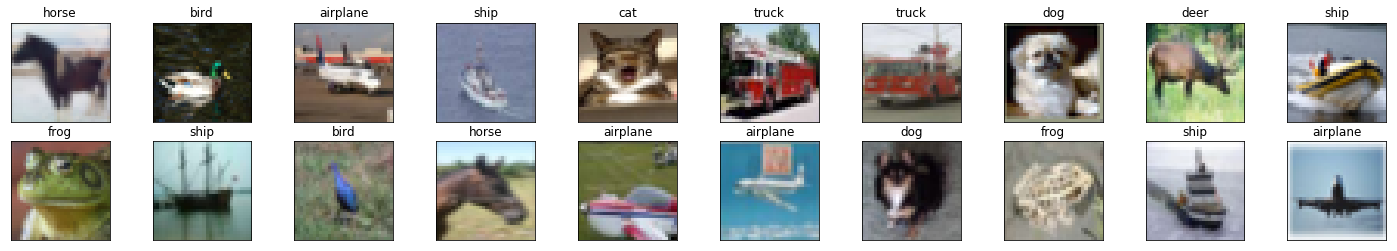

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Viewing an Image in More Detail

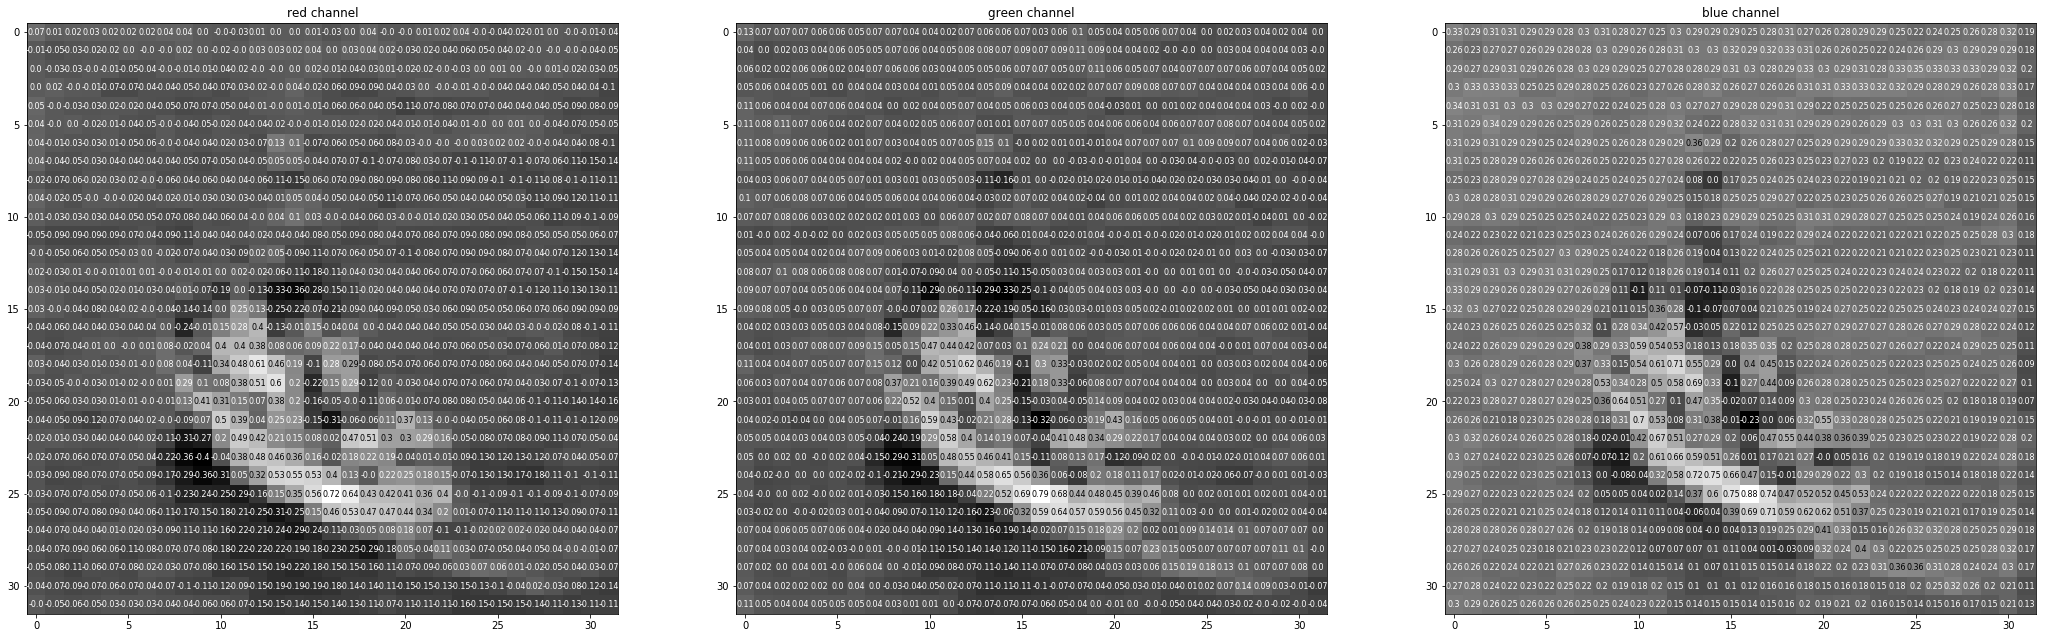

In [9]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1,3, idx+1)
    img = rgb_img[idx]
    ax.imshow(img, cmap = 'gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range (height):
            val = round(img[x][y], 2) if img[x][y] != 0 else 0
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment = 'center',
                        verticalalignment = 'center', size = 8,
                       color = 'white' if img[x][y]<thresh else 'black')

Here, we are looking at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

## Defining the Network Architecture

In [16]:

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()
print(model)



Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


In [17]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Training the Network:

In [21]:
epochs = 30
valid_loss_min = np.Inf

for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
        
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    ###### saving thee model if validation loss has decreased ######
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 1.464719 	Validation Loss: 1.353788
Validation loss decreased (inf --> 1.353788).  Saving model ...
Epoch: 1 	Training Loss: 1.352168 	Validation Loss: 1.266630
Validation loss decreased (1.353788 --> 1.266630).  Saving model ...
Epoch: 2 	Training Loss: 1.254231 	Validation Loss: 1.169704
Validation loss decreased (1.266630 --> 1.169704).  Saving model ...
Epoch: 3 	Training Loss: 1.175575 	Validation Loss: 1.080668
Validation loss decreased (1.169704 --> 1.080668).  Saving model ...
Epoch: 4 	Training Loss: 1.096557 	Validation Loss: 1.055381
Validation loss decreased (1.080668 --> 1.055381).  Saving model ...
Epoch: 5 	Training Loss: 1.030009 	Validation Loss: 0.987887
Validation loss decreased (1.055381 --> 0.987887).  Saving model ...
Epoch: 6 	Training Loss: 0.974933 	Validation Loss: 0.935549
Validation loss decreased (0.987887 --> 0.935549).  Saving model ...
Epoch: 7 	Training Loss: 0.926929 	Validation Loss: 0.898751
Validation loss decreased (0.93554

In [22]:
model.load_state_dict(torch.load('model_cifar.pt'))

## Testing the Network:

In [25]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.711167

Test Accuracy of airplane: 84% (845/1000)
Test Accuracy of automobile: 86% (861/1000)
Test Accuracy of  bird: 64% (646/1000)
Test Accuracy of   cat: 48% (489/1000)
Test Accuracy of  deer: 74% (748/1000)
Test Accuracy of   dog: 69% (693/1000)
Test Accuracy of  frog: 80% (803/1000)
Test Accuracy of horse: 82% (827/1000)
Test Accuracy of  ship: 84% (842/1000)
Test Accuracy of truck: 84% (844/1000)

Test Accuracy (Overall): 75% (7598/10000)


## Visualizing Sample Test Results:

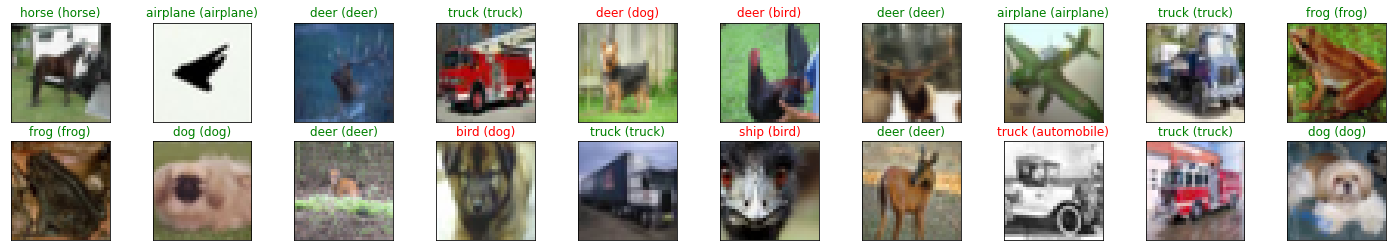

In [32]:
data_iter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]), color=("green" if preds[idx]==labels[idx].item() else "red"))

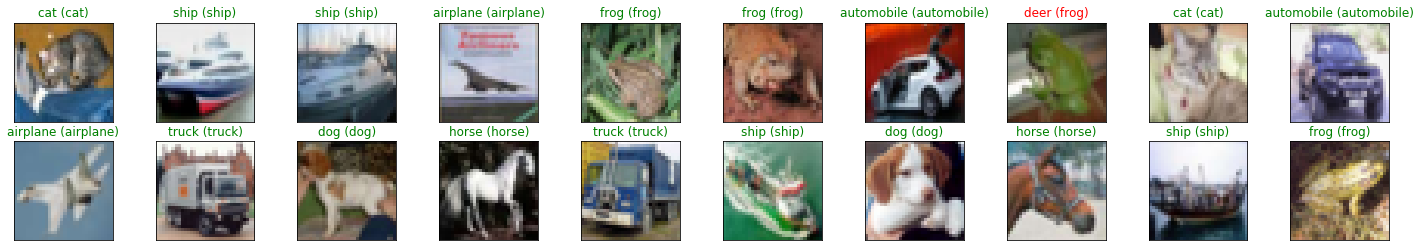

In [33]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]), color=("green" if preds[idx]==labels[idx].item() else "red"))